## Regularization demo
2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [33]:
using Distributions
using Plots
using Statistics
using Printf
using Plots.PlotMeasures
include("__init__.jl")

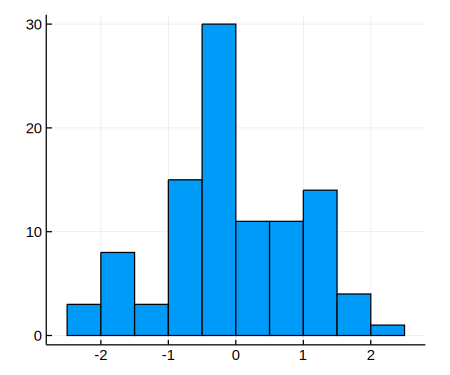

In [3]:
N = 100
y = rand(Normal(),N,1)
histogram(y,
    thickness_scaling=5,
    size=(1800,1500),
    legend=false
)

- Imagine your training set only contains the $y$-values, and they are shown above.
- How can you predict a new $y$?
- Reasonable idea: predict the mean value.

In [4]:
mutable struct MeanPredictor
    predict
end
function initializeMeanPredictor(x)
    function predict()
        return mean(x)
    end
    return MeanPredictor(predict)
end
mp = initializeMeanPredictor(y)
mp.predict()

-0.07391725221350744

Now imagine we have one feature $x$. 

In [5]:
x = y ./ 2 + rand(Normal(),N,1) ./ 3

100×1 Array{Float64,2}:
  0.8831635512739546  
  0.8751047181922496  
 -0.4720764222393786  
 -0.51812664538706    
  0.3591094161675397  
  0.7445285485029494  
 -0.9345408501260282  
 -1.0085789859263723  
  0.06409746757617311 
  0.4068747768671814  
  0.4034029096924158  
 -0.0956580327050674  
 -1.0838238181257316  
  ⋮                   
 -0.018448639194782207
 -0.4327510004459679  
  0.052918241021443366
 -0.18648778922064535 
 -0.02602198889291544 
 -0.1619346534420139  
  0.5220184414789591  
  0.20071055103419677 
  0.6282703036333255  
 -0.36024150458944937 
 -0.02862664924272551 
  0.14748064695014118 

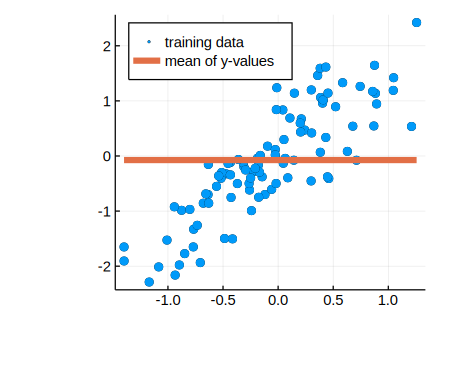

In [9]:
scatter(x,y,label="training data",
    markersize=20,
    thickness_scaling=5,
    size=(1800,1500),
    legend=:topleft
)
m = mean(y)
plot!([minimum(x),maximum(x)],[m,m], linewidth=5, label="mean of y-values")

- So, what we were doing was sort of like linear regression with $w=0$.
- Ok, but, why not use this feature?

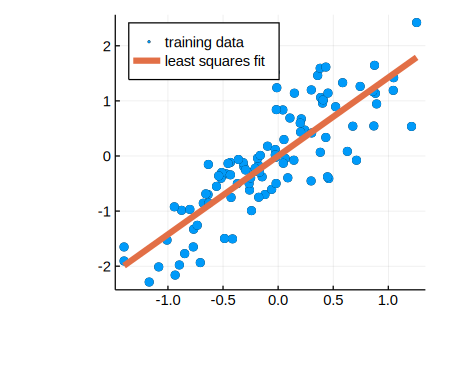

In [11]:
scatter(x,y,
    markersize=20,
    label="training data",
    thickness_scaling=5,
    size=(1800,1500),
    legend=:topleft
)
w = sum(x .* y) / sum(x .* x)
plot!(x,w .* x,
    linewidth=5,
    label="least squares fit"
)

- But what if we don't trust this feature that much?
- Let's take a compromise between our prior model (mean value) and our new model.
- _We can achieve this by penalizing large values of $w$_.
- The loss becomes

$$\sum_{i=1}^n (wx_i-y_i)^2 + \lambda w^2$$

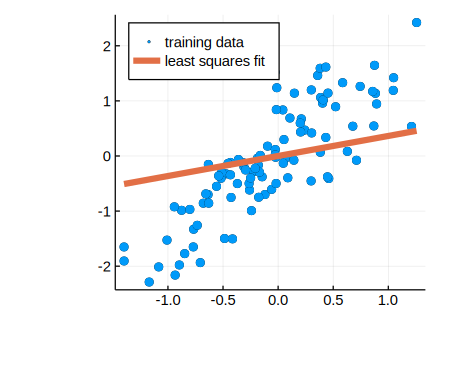

In [12]:
scatter(x,y,
    markersize=20,
    label="training data",
    thickness_scaling=5,
    size=(1800,1500),
    legend=:topleft
)
w = sum(x .* y)/ (sum(x .* x)+100)
plot!(x,w .* x, linewidth=5,label="least squares fit")

- Makes sense in light of the intuition: more features makes linear regression overfit.
- This is an alternative to the hard decisions of feature selection.

## Regularization demo

### Generate some synthetic data in 1-d

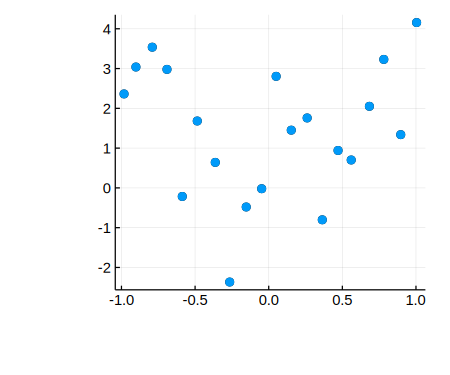

In [15]:
N = 20
X = range(-1,stop=1,length=N)+rand(Normal(),N).*0.01
X=reshape(X,length(X),1)
y = rand(Normal(),N,1) + 3 .* X .^ 2

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    thickness_scaling=5,
    size=(1800,1500),
    legend=false
)

### Fit (interpolate) with degree $N-1$ polynomial

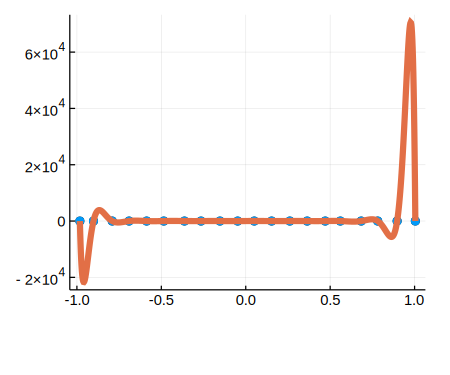

In [27]:
pf = initializePolynomialFeatures(X,degree=N-1)
Z = pf.transform(X)
v = Z'*Z \ Z'*y
grid = reshape(range(minimum(X),stop=maximum(X),length=1000),1000,1)
grid_poly = initializePolynomialFeatures(grid,degree=N-1).transform(grid)

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    thickness_scaling=5,
    size=(1800,1500),
    left_margin=-200px,
    legend=false
)
plot!(grid, grid_poly*v,
    linewidth=5
)

In [28]:
Printf.@printf("%s\n",v)
Printf.@printf("%d",maximum(broadcast(abs,v)))

[1.92798; 335.352; -260.078; -33089.8; 12792.0; 9.53521e5; -250968.0; -1.21062e7; 2.33334e6; 8.0313e7; -1.12552e7; -3.02086e8; 2.94971e7; 6.63771e8; -4.19789e7; -8.39162e8; 3.0187e7; 5.62708e8; -8.49439e6; -1.54384e8]
839162053

Problem: this results are crazy (overfitting). Interpretation: many large weights are cancelling each other out at the data points.

### Solution 1: lower degree polynomial

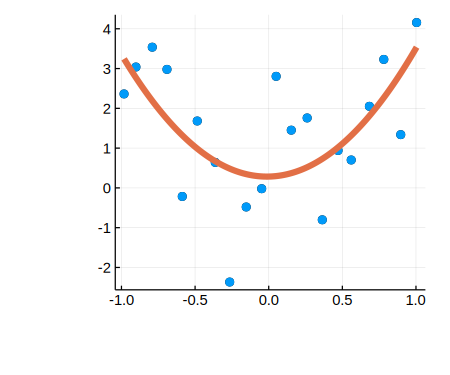

In [30]:
pf = initializePolynomialFeatures(X,degree=2)
Z = pf.transform(X)

v = Z'*Z \ Z'*y

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    thickness_scaling=5,
    size=(1800,1500),
    legend=false
)
grid_poly = pf.transform(grid)
plot!(grid, grid_poly*v,
    linewidth=5
)

In [31]:
Printf.@printf("%s\n",v)
Printf.@printf("%d",maximum(broadcast(abs,v)))

[0.28492; 0.0790719; 3.14544]
3

Discussion:
- The lower degree polynomial looks good. 
- But if the true relationship really was complicated? Then if we restricted the degree of the polynomial, we'd miss out on it. 

### Solution 2: add L2-regularization

- Let's let the data decide how complex our model needs to be. 
- This is just like the complexity penalty from before, but now we can still optimize the loss easily.

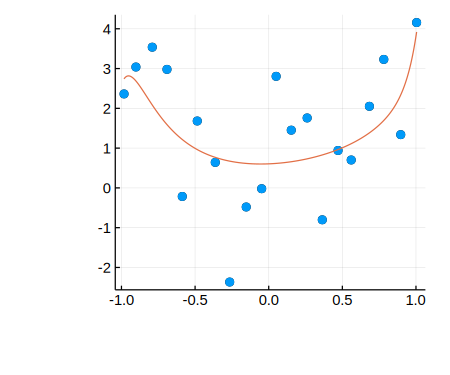

In [35]:
pf = initializePolynomialFeatures(X,degree=19)
Z = pf.transform(X)

λ = 1
v = (Z'*Z + λ*eye(size(Z)[2])) \ Z'*y

plot(X,y,
    seriestype=:scatter,
    markersize=20,
    thickness_scaling=5,
    size=(1800,1500),
    legend=false
)
grid_poly = pf.transform(grid)
plot!(grid, grid_poly*v)

In [36]:
size(Z)

(20, 20)

In [37]:
Printf.@printf("%s\n",v)
Printf.@printf("%d",maximum(broadcast(abs,v)))

[0.604763; 0.149463; 1.34012; -0.468081; 0.865257; -0.268357; 0.430103; -0.101371; 0.170485; 0.0277239; 0.0310185; 0.128077; -0.0369899; 0.206066; -0.0643567; 0.266599; -0.0693268; 0.313502; -0.0624236; 0.349736]
1

Discussion:
- Regularization helped! Even though we used a degree $N-1$ polynomial, we didn't end up with a crazy model.
- We can add regularization to many models, not just least squares with a polynomial basis.

#### More regularization thoughts (to read after class):

Imagine minimizing $f(w)=(w-1)^2+\lambda w^2$ with respect to $w$. The left-hand term wants to set $w=1$ to be minimized (equal to zero, in this case, since something squared can't be negative). The right-hand term wants to set $w=0$ to be minimized (again, equal to zero). What if we set $w=0$? Then we get a penalty of $1$ from the left-hand term and a penalty of zero from the right-hand term, for a total of $f(0)=1$. Now what if we set $w=1$? Then the left-hand term gives a penalty of zero and the right-hand term equals $\lambda$, so $f(1)=\lambda$. Then if $\lambda=1$ these two solutions are equally desirable, but if $\lambda=100$ then it becomes much better to set $w=0$ than $w=1$ and on the other hand if $\lambda=0.01$ then the opposite is true. So as you can see $\lambda$ controls the relative strength or "importance" of the two terms in our objective function.
 
In this particular case, because I picked such a simple example, we could also do the math by hand:
 
$$f(w)=(w-1)^2+\lambda w^2=(\lambda+1)w^2-2w+1$$
 
Setting the derivative to zero:
 
$$2(\lambda+1)w-2=0$$
 
yields
 
$$w=\frac{1}{1+\lambda}$$
 
So now we see it very clearly: if $\lambda=1$ then the solution lies at $0.5$ which is sensible, since the two terms are weighted equally. But as $\lambda$ grows the solution moves towards $w=0$, and as $\lambda$ shrinks towards zero the solutions goes towards $w=1$. 
 
All this is fairly analogous to linear regression situation except that

- $w$ is $d$-dimensional instead of $1$-dimensional
- the minimizer of the left-hand side is the $w$ that minimizes training error
 
So $\lambda$ controls the relative importance of training error vs. regularization.